In [29]:
import numpy as np
import nashpy as nash
import axelrod as axl
import random
import time
import math
import warnings
import json
from pathlib import Path
import pandas as pd
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def who_is_playing(num_of_opponents, long_run_strategies=False):
    """
    A function to choose which strategies will be playing against the Defector, where:

    'num_of_opponents' is a numeric variable which states how many players will 
    be competing (EXCLUDING the Defector); and

    'long_run_strategies' is a Boolean variable which states whether strategies 
    which have a long running time should be included in the competitors or 
    not. It has a default value of False.

    A list containing the selected strategies is returned.
    """

    if long_run_strategies == True:
        filterstrategies = {
            "manipulates_state": False,
            "manipulates_source": False,
            "inspects_source": False,
        }
    else:
        filterstrategies = {
            "long_run_time": False,
            "manipulates_state": False,
            "manipulates_source": False,
            "inspects_source": False,
        }

    filtered_strategies = axl.filtered_strategies(filterstrategies)
    filtered_strategies.remove(axl.Defector)

    opponent_strategies = random.sample(filtered_strategies, num_of_opponents)
    list_of_players = [opponent() for opponent in opponent_strategies]
    list_of_players.append(axl.Defector())

    return list_of_players

In [8]:
def get_game(tournament_rep, player_list, prob_of_game_ending, noise):

    """
    A function which runs a tournament of A Prisoner's Dilemma and returns a dictionary containing the following: 'payoff matrix obtained' (an output from the Axelrod tournament function), 'number of tournament repeats' (from 'tournament_rep'), 'probability of game ending' (from 'prob_of_game_ending) and 'noise' (from 'noise'), where:

    'tournament_rep' is a numeric variable stating how many times the tournament should be executed;

    'player_list' is a list containing instances of specific strategy classes obtained from the Axelrod library;

    'prob_of_game_ending' is a numeric variable between 0 and 1 which states the probability of the tournament ending on any specific turn; and

    'noise' is a numeric variable between 0 and 1 as described on https://axelrod.readthedocs.io/en/stable/tutorials/further_topics/noisy_tournaments.html and https://axelrod.readthedocs.io/en/stable/reference/glossary.html#noise.
    """

    tournament = axl.Tournament(
        player_list,
        prob_end=prob_of_game_ending,
        repetitions=tournament_rep,
        noise=noise,
    )
    tournament_results = tournament.play(progress_bar=False)

    mean_payoff_matrix = np.array(tournament_results.payoff_matrix)

    get_game_output_dict = {
        "payoff matrix obtained": mean_payoff_matrix,
        "number of tournament repeats": tournament_rep,
        "probability of game ending": prob_of_game_ending,
        "noise": noise,
    }
    return get_game_output_dict

In [9]:
def timing_algorithm(algorithm, tournament_rep, prob_of_game_ending, noise):

    """
    A function which collects the time executed for a specific algorithm to calculate the Nash equilibria, where:

    'algorithm' is a string containing any of "support_enumeration", "vertex_enumeration" or "lemke_howson";

    'tournament_rep' is a numeric variable stating the number of repeats the Prisoner's Dilemma tournament (which is used to obtain the game matrix);
    
    'prob_of_game_ending' is a numeric variable between 0 and 1 stating the probability of a match ending after any turn in the tournament; and

    'noise' is a numeric variable between 0 and 1 stating the amount of noise to be included in the tournament.

    The function returns a dictionary with the number of players (2-15) as keys and each having a list containing the times to execute the algorithm given. Note, each number of players is repeated 50 times.
    """

    player_dictionary = {}
    for opponent_num in range(1, 15):
        execution_time = []
        for same_num in range(50):
            players = who_is_playing(num_of_opponents=opponent_num)
            play_tournament = get_game(tournament_rep=tournament_rep, player_list=players, prob_of_game_ending=prob_of_game_ending, noise=noise)
            payoff_matrix = play_tournament["payoff matrix obtained"]
            game = nash.Game(payoff_matrix, payoff_matrix.transpose())
            
            if algorithm == "support_enumeration":
                initial_time = time.perf_counter()
                game.support_enumeration()
                final_time = time.perf_counter()
            elif algorithm == "vertex_enumeration":
                initial_time = time.perf_counter()
                game.vertex_enumeration()
                final_time = time.perf_counter()
            elif algorithm == "lemke_howson":
                initial_time = time.perf_counter()
                game.lemke_howson_enumeration()
                final_time = time.perf_counter()
            else:
                raise Exception(
                    " algorithm should be one of 'support_enumeration', 'vertex_enumeration', or 'lemke_howson'. "
                )

            execution_time.append(final_time - initial_time)

        player_dictionary[str(len(players))] = execution_time
    return(player_dictionary)

In [ ]:
support_enumeration = timing_algorithm(algorithm="support_enumeration", tournament_rep=100, prob_of_game_ending=0.2, noise=0)

In [ ]:
with open("timings-dict-se.json", "w") as json_file:
        save_to_json = json.dumps(support_enumeration)
        json_file.write(save_to_json)

In [ ]:
vertex_enumeration = timing_algorithm(algorithm="vertex_enumeration", tournament_rep=100, prob_of_game_ending=0.2, noise=0)

In [ ]:
with open("timings-dict-ve.json", "w") as json_file:
        save_to_json = json.dumps(vertex_enumeration)
        json_file.write(save_to_json)

In [ ]:
lemke_howson = timing_algorithm(algorithm="lemke_howson", tournament_rep=100, prob_of_game_ending=0.2, noise=0)

In [ ]:
with open("timings-dict-lh.json", "w") as json_file:
        save_to_json = json.dumps(lemke_howson)
        json_file.write(save_to_json)

In [10]:
with open("timings-dict-se.json", "r") as se_timingfile:
    se_timingdict = se_timingfile.read()
se_timings = json.loads(se_timingdict)

In [11]:
with open("timings-dict-ve.json", "r") as ve_timingfile:
    ve_timingdict = ve_timingfile.read()
ve_timings = json.loads(ve_timingdict)

In [12]:
with open("timings-dict-lh.json", "r") as lh_timingfile:
    lh_timingdict = lh_timingfile.read()
lh_timings = json.loads(se_timingdict)

In [33]:
se_data = pd.DataFrame.from_dict(se_timings).melt(var_name="Number of Players", value_name="Time")
se_data['Algorithm Used'] = list(itertools.repeat("Support Enumeration", 700))
se_data["Time"] = se_data["Time"].apply(lambda x: math.log(x))
se_data.head()

,Number of Players,Time,Algorithm Used
0,2,-12.075044,Support Enumeration
1,2,-12.404523,Support Enumeration
2,2,-12.454535,Support Enumeration
3,2,-11.736069,Support Enumeration
4,2,-12.356896,Support Enumeration


In [32]:
ve_data = pd.DataFrame.from_dict(ve_timings).melt(var_name="Number of Players", value_name="Time")
ve_data['Algorithm Used'] = list(itertools.repeat("Vertex Enumeration", 700))
ve_data["Time"] = ve_data["Time"].apply(lambda x: math.log(x))
ve_data.head()

,Number of Players,Time,Algorithm Used
0,2,-12.226276,Vertex Enumeration
1,2,-12.621588,Vertex Enumeration
2,2,-12.591735,Vertex Enumeration
3,2,-12.454534,Vertex Enumeration
4,2,-11.928440,Vertex Enumeration


In [31]:
lh_data = pd.DataFrame.from_dict(lh_timings).melt(var_name="Number of Players", value_name="Time")
lh_data['Algorithm Used'] = list(itertools.repeat("Lemke Howson Enumeration", 700))
lh_data["Time"] = lh_data["Time"].apply(lambda x: math.log(x))
lh_data.head()

,Number of Players,Time,Algorithm Used
0,2,-12.075044,Lemke Howson Enumeration
1,2,-12.404523,Lemke Howson Enumeration
2,2,-12.454535,Lemke Howson Enumeration
3,2,-11.736069,Lemke Howson Enumeration
4,2,-12.356896,Lemke Howson Enumeration


In [19]:
timing_data = pd.concat([se_data, ve_data, lh_data])
timing_data.head(), timing_data.dtypes

(  Number of Players      Time       Algorithm Used
 0                 2  0.000006  Support Enumeration
 1                 2  0.000004  Support Enumeration
 2                 2  0.000004  Support Enumeration
 3                 2  0.000008  Support Enumeration
 4                 2  0.000004  Support Enumeration,
 Number of Players     object
 Time                 float64
 Algorithm Used        object
 dtype: object)

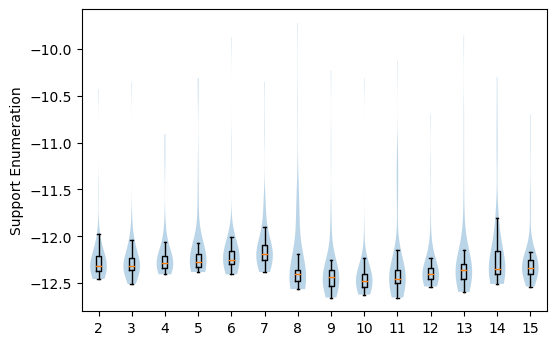

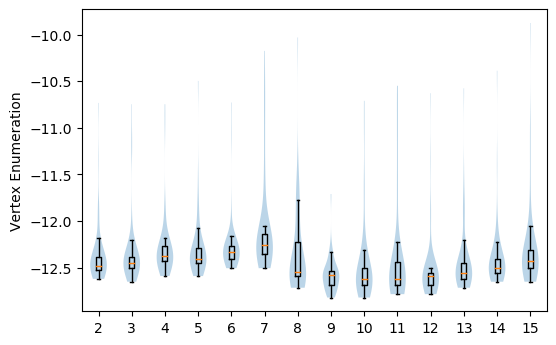

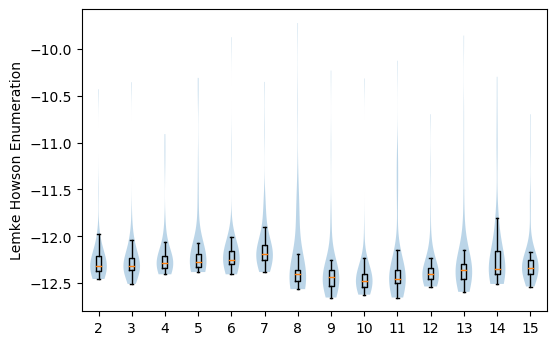

In [35]:
path_for_images = Path("../../images/folk_thm/")
path_for_images.mkdir(parents=True, exist_ok=True)

colour = "tab:blue"

file_name = "se_data_time_violinplot.pdf"
timings_p_violinplot_path = path_for_images / file_name
fig, ax = plt.subplots(1, dpi=100)
for pos, (num_of_players, times) in enumerate(se_data.groupby("Number of Players")["Time"]):
    vplot = ax.violinplot(times, positions=[pos], showextrema=False)
    ax.boxplot(times, positions=[pos], sym="")
    for body in vplot["bodies"]:
        body.set_facecolor(colour)
ax.set_xticklabels(timing_data["Number of Players"].unique())
ax.set_ylabel("Support Enumeration")
plt.savefig(timings_p_violinplot_path)


file_name = "ve_data_time_violinplot.pdf"
timings_p_violinplot_path = path_for_images / file_name
fig, ax = plt.subplots(1, dpi=100)
for pos, (num_of_players, times) in enumerate(ve_data.groupby("Number of Players")["Time"]):
    vplot = ax.violinplot(times, positions=[pos], showextrema=False)
    ax.boxplot(times, positions=[pos], sym="")
    for body in vplot["bodies"]:
        body.set_facecolor(colour)
ax.set_xticklabels(timing_data["Number of Players"].unique())
ax.set_ylabel("Vertex Enumeration")
plt.savefig(timings_p_violinplot_path)


file_name = "lh_data_time_violinplot.pdf"
timings_p_violinplot_path = path_for_images / file_name
fig, ax = plt.subplots(1, dpi=100)
for pos, (num_of_players, times) in enumerate(lh_data.groupby("Number of Players")["Time"]):
    vplot = ax.violinplot(times, positions=[pos], showextrema=False)
    ax.boxplot(times, positions=[pos], sym="")
    for body in vplot["bodies"]:
        body.set_facecolor(colour)
ax.set_xticklabels(timing_data["Number of Players"].unique())
ax.set_ylabel("Lemke Howson Enumeration")
plt.savefig(timings_p_violinplot_path)